# American Sign Language Classification

This notebook shows the TensorFlow Lite model conversion and inference processes for the **American Sign Language Classification** model. This model is capable of classifying alphabets of american sign language:

![](https://i.imgur.com/kxEkExw.png)

## Imports

In [1]:
import os
import numpy as np
from tqdm import tqdm
from imutils import paths
from pprint import pprint
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

2.8.0


## Download the test-data


Dataset Source: [Kaggle Link](https://www.kaggle.com/datasets/grassknoted/asl-alphabet)

In [13]:
!pip install -q gdown==4.3.1
!gdown --id 1upI6mKOxD-ijnWQ6j9fbVRmHPFnyFhKh
!unzip -qq asl_alphabet_train.zip

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
Downloading...
From: https://drive.google.com/uc?id=1upI6mKOxD-ijnWQ6j9fbVRmHPFnyFhKh
To: /content/asl_alphabet_train.zip
100% 1.10G/1.10G [00:15<00:00, 71.6MB/s]


## Download the pre-trained weights

In [8]:
!wget -q https://github.com/sayannath/American-Sign-Language-Detection/releases/download/1.0.0/asl_classifier.zip
!unzip -qq asl_classifier.zip

replace asl_classifier/keras_metadata.pb? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace asl_classifier/saved_model.pb? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace asl_classifier/variables/variables.data-00000-of-00001? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace asl_classifier/variables/variables.index? [y]es, [n]o, [A]ll, [N]one, [r]ename: y


In [9]:
SAVED_MODEL_FILE = 'asl_classifier/'
TF_LITE_MODEL_FILE = 'asl_classifier.tflite'

## Conversion of model into TF-Lite

In [10]:
# Load the save model
model = keras.models.load_model(SAVED_MODEL_FILE)

# Convert the save model into tflite
converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()
open(TF_LITE_MODEL_FILE, 'wb').write(tflite_model)

print('Model size is %f MBs.' % (len(tflite_model) / 1024 / 1024.0))

INFO:tensorflow:Assets written to: /tmp/tmpo8i1mdpv/assets


Model size is 3.157486 MBs.


## Check tensor-shape

In [11]:
interpreter = tf.lite.Interpreter(model_path = TF_LITE_MODEL_FILE)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [  1 224 224   3]
Input Type: <class 'numpy.float32'>
Output Shape: [ 1 29]
Output Type: <class 'numpy.float32'>


## Test Dataset

### Data parsing

In [15]:
image_paths = list(paths.list_images("asl_alphabet_train"))
np.random.shuffle(image_paths)
print(image_paths[:3])

['asl_alphabet_train/E/E341.jpg', 'asl_alphabet_train/X/X2715.jpg', 'asl_alphabet_train/J/J672.jpg']


### Class Count

In [18]:
labels = []
for image_path in tqdm(image_paths):
    label = image_path.split("/")[1]
    labels.append(label)
class_count = Counter(labels)
print() 
pprint(class_count) 

100%|██████████| 87000/87000 [00:00<00:00, 690753.68it/s]


Counter({'E': 3000,
         'X': 3000,
         'J': 3000,
         'L': 3000,
         'space': 3000,
         'S': 3000,
         'M': 3000,
         'W': 3000,
         'O': 3000,
         'C': 3000,
         'D': 3000,
         'I': 3000,
         'R': 3000,
         'A': 3000,
         'V': 3000,
         'Z': 3000,
         'K': 3000,
         'nothing': 3000,
         'del': 3000,
         'N': 3000,
         'Q': 3000,
         'B': 3000,
         'P': 3000,
         'U': 3000,
         'T': 3000,
         'F': 3000,
         'Y': 3000,
         'H': 3000,
         'G': 3000})


### Split the dataset

In [19]:
TRAIN_SPLIT = 0.9

i = int(len(image_paths) * TRAIN_SPLIT)

train_paths = image_paths[:i]
train_labels = labels[:i]
test_paths = image_paths[i:]
test_labels = labels[i:]

print(len(train_paths), len(test_paths))

78300 8700


### Encoding the labels

In [20]:
le = LabelEncoder()
train_labels_le = le.fit_transform(train_labels)
validation_labels_le = le.transform(test_labels)
print(train_labels_le[:5])

[ 4 23  9 11 28]


## Define the hyperameters

In [21]:
IMG_SIZE = 224
BATCH_SIZE = 16

## Dataloader utilities

In [22]:
@tf.function
def preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return (image, label)

## Testing data pipeline

In [23]:
test_ds = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))

test_ds = (
    test_ds
    .map(preprocess_image)
    .batch(BATCH_SIZE)
)

In [24]:
test_imgs, test_labels = next(iter(test_ds))
print(test_imgs.shape)

(16, 224, 224, 3)


## Resizing the tensor-shape

In [25]:
interpreter.resize_tensor_input(input_details[0]['index'], (16, 224, 224, 3))
interpreter.resize_tensor_input(output_details[0]['index'], (16, 29))
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [ 16 224 224   3]
Input Type: <class 'numpy.float32'>
Output Shape: [16 29]
Output Type: <class 'numpy.float32'>


## Making prediction on the test-data with the TF Lite model

In [26]:
interpreter.set_tensor(input_details[0]['index'], test_imgs)
interpreter.invoke()

tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])

print("Prediction results shape:", tflite_model_predictions.shape)
prediction_classes_le = np.argmax(tflite_model_predictions, axis=1)
prediction_classes = le.inverse_transform(prediction_classes_le)

Prediction results shape: (16, 29)


## Results after inferencing

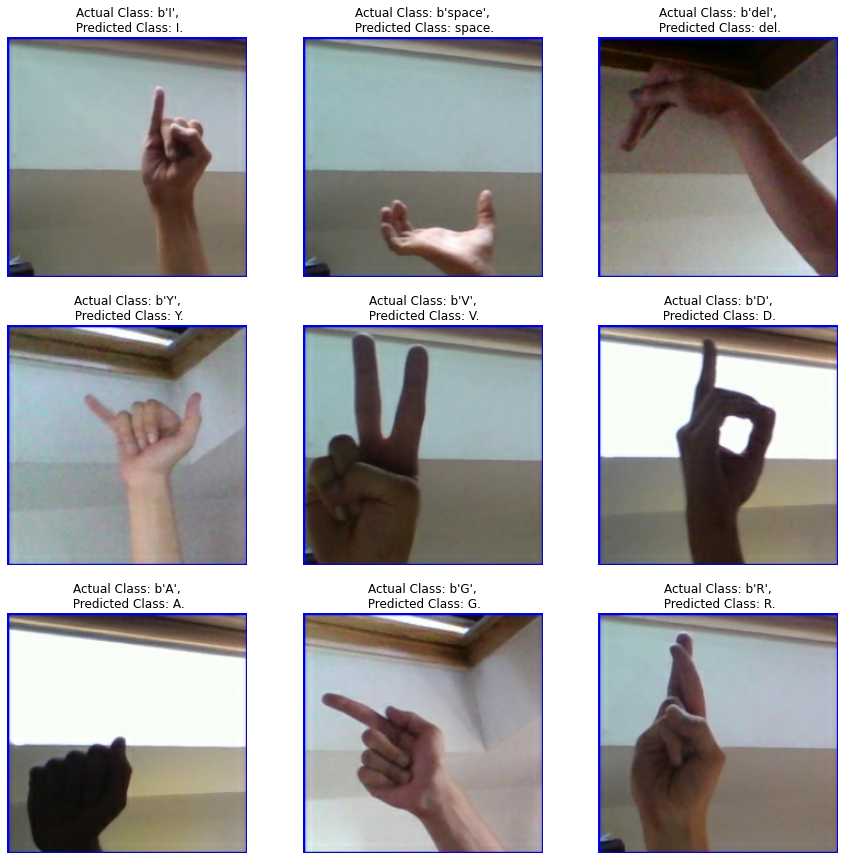

In [27]:
plt.figure(figsize=(15, 15))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(test_imgs[i].numpy())
    plt.title(f"Actual Class: {test_labels[i]},\n Predicted Class: {prediction_classes[i]}.")
    plt.axis("off")